In [ ]:
"""
 - cross validation using multicore 
 - diff inside fingerprint 
 - test different similarity methods
 - test impairments - add mu/std in dBm  
"""

In [1]:
from utils import *
import sys, os, random
from multiprocessing import Pool, cpu_count
from matplotlib.ticker import FormatStrFormatter
np.set_printoptions(precision=3)

datadir = "../data.upb/precis/02-precis-redmi-pixel4a/"
pix_etaje = [ "0-pixel-04-06-2021_19-34-41.json"]  
red_etaje = [ "0-redmi-04-06-2021_19-33-47.json"]


In [2]:
datadir = "../data.upb/precis/01-precis-redmi-pixel4a/nowl/"
pix_etaje = [
"0-pixel-04-03-2021_15-32-38.json.gz",
"1-pixel-25-02-2021_21-16-46.json.gz",
"2-pixel-25-02-2021_16-27-45.json.gz",
"3-pixel-04-03-2021_16-18-50.json.gz",
"4-pixel-04-03-2021_16-43-50.json.gz",
"5-pixel-04-03-2021_17-11-32.json.gz",
"6-pixel-17-03-2021_12-52-29.json.gz",
"7-pixel-17-03-2021_13-14-36.json.gz"]

red_etaje = [
"0-redmi-04-03-2021_15-31-12.json.gz",
"1-redmi-25-02-2021_21-16-10.json.gz",
"2-redmi-25-02-2021_16-27-08.json.gz",
"3-redmi-04-03-2021_16-18-52.json.gz",
"4-redmi-04-03-2021_16-43-45.json.gz",
"5-redmi-04-03-2021_17-11-30.json.gz",
"6-redmi-17-03-2021_12-52-29.json.gz",
"7-redmi-17-03-2021_13-14-39.json.gz"]

In [3]:
retaje = []
for e in red_etaje: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    retaje.append(etaj)

petaje = []
for e in pix_etaje: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    petaje.append(etaj)
    

In [9]:
import numpy as np
from scipy.spatial.distance import *
from scipy.stats import ks_2samp, chisquare
import copy 

def impair_wifi(c):
    for f in c['fingerprints']:
        for mac in f['wifi'].keys():
            f["wifi"][mac]['rssi']  = list(map(lambda x: x - 10, f["wifi"][mac]['rssi']))

            
def merge_wifi_fingerprints(flist):
    fingerprint = copy.deepcopy(flist[0])
    for f2 in copy.deepcopy(flist[1:]):
        if not "wifi" in f2.keys():
            continue
        for mac in f2["wifi"].keys():
            if not mac in fingerprint["wifi"].keys():
                fingerprint["wifi"][mac] = f2["wifi"][mac]
                #fingerprint["wifi"][mac]['rssi'] = []
            else:
                fingerprint["wifi"][mac]['rssi'].extend(f2["wifi"][mac]['rssi'])
            fingerprint["wifi"][mac]['rssi'].sort()    
    return fingerprint


def compare_locations(c1, c2, simil_method = braycurtis,  selection = 'Average', dif = True):
    rssi1 = []
    rssi2 = []
    w = [] #weight for braycurtis
    
    # take the first fingerprint in the list 
    #wifi1 = c1['fingerprints'][0]['wifi']
    #wifi2 = c2['fingerprints'][0]['wifi']

    # take a random fingerprint in the list 
    #wifi1 = c1['fingerprints'][random.randint(0,3)]['wifi']
    #wifi2 = c2['fingerprints'][random.randint(0,3)]['wifi']

    # first & third - as if measuring twice at 180 degrees
    #wifi1 = merge_wifi_fingerprints([c1['fingerprints'][0], c1['fingerprints'][2]])['wifi']
    #wifi2 = merge_wifi_fingerprints([c2['fingerprints'][0], c2['fingerprints'][2]])['wifi']
    
    #merge all existing fingerprints for each collection
    wifi1 = merge_wifi_fingerprints(c1['fingerprints'])['wifi']
    wifi2 = merge_wifi_fingerprints(c2['fingerprints'])['wifi']
    
    # all power received by the query
    power1 = 0
    for ap in wifi1:
        power1 += np.sum(wifi1[ap]['rssi'])
        
    common_aps = list(set(wifi1.keys()) & set(wifi2.keys()))
    #print("common aps=", len(common_aps))
    
    # No APs in common -> similarity = 1
    if not common_aps:
        return 1

    # TODO: find the best metric
    # If not enough common APs -> similarity = 1
    if len(common_aps) * 3 <= len(wifi1.keys()) or len(common_aps) < 3:
        return 1

    for ap in common_aps:
        
        if selection == 'Bestdir':
            for f1 in c1['fingerprints']: # all fingerprint dirs in the query 
                if not ap in f1['wifi'].keys():
                    continue
                m1 = np.average(adjust_rssi(f1['wifi'][ap]['rssi']))
                best = 100                
                for f2 in c2['fingerprints']: 
                    if not ap in f2['wifi'].keys():
                        continue
                    m2 = np.average(adjust_rssi(f2['wifi'][ap]['rssi']))
                    if(math.fabs(m2-m1)) < best:  # find one dir with closest RSSI
                        best = math.fabs(m2-m1)
                        bestf = m2
                rssi1.append(m1)
                rssi2.append(bestf)
                
        # Take only the first RSSI value                
        if selection == 'First':
            rssi1.append(wifi1[ap]['rssi'][0])
            rssi2.append(wifi2[ap]['rssi'][0])

        # Make an average of all RSSI values
        if selection == 'Average':
            #rssi1.append(adjust_rssi(np.average(wifi1[ap]['rssi']))[0])
            #rssi2.append(adjust_rssi(np.average(wifi2[ap]['rssi']))[0])
            rssi1.append(np.average(wifi1[ap]['rssi']))
            rssi2.append(np.average(wifi2[ap]['rssi']))
            #w.append(min(len(wifi1[ap]['rssi']), len(wifi2[ap]['rssi'])))

        if selection == 'Median':
            rssi1.append(np.median(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.median(adjust_rssi(wifi2[ap]['rssi'])))

        if selection == 'Mean':
            rssi1.append(np.mean(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.mean(adjust_rssi(wifi2[ap]['rssi'])))

        if selection == 'Std':
            rssi1.append(np.std(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.std(adjust_rssi(wifi2[ap]['rssi'])))

        if selection == 'Max':
            rssi1.append(np.max(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.max(adjust_rssi(wifi2[ap]['rssi'])))
            
        if selection == 'KS':
            _, p = ks_2samp(wifi1[ap]['rssi'], wifi2[ap]['rssi'])
            rssi1.append(p)
            rssi2.append(1.0)

        if selection == 'Tempered':
            rss_1.append(np.average(rssi_v[index][key]) * random.uniform(0.8, 1.2))
            rss_2.append(np.average(rssi_v[r][key]) * random.uniform(0.8, 1.2))
    
    
    rssi11 = []
    rssi22 = []
    if selection != 'KS':
        
        if (dif == True):
            #print(rssi1)
            rssi11.append(np.diff(rssi1, append=rssi1[0]))
            rssi22.append(np.diff(rssi2, append=rssi2[0]))
            rssi1 = rssi11
            rssi2 = rssi22        

    #print(f"1={rssi1}\n2={rssi2}\ncommon={common_aps}")
    #if selection != 'KS':
    #    rssi1 = list(map(lambda x: x - np.mean(rssi1), rssi1))
    #    rssi2 = list(map(lambda x: x - np.mean(rssi2), rssi2))
    return simil_method(tuple(rssi1), tuple(rssi2))
#        return simil_method(tuple(rssi1), tuple(rssi2))*sum(rssi1)/power1
# weigh final result with used power/total power   

In [ ]:
# Generate a matrix (list of lists) for a collection (etaj)
# [point_index, index_of_closest_pt, dist_to_closest_pt, index_diff, dist_2_best_neighbor]
def test_allvsall(collection, selection='Average', simil_method = braycurtis, dif = True):
    lc = len(collection)
    #arr = [[0]*lc]*lc - nu merge!
    arr = [[0 for i in range(lc)] for j in range(lc)]
    for l in range(0, lc):
        for c in range(0, l):
            arr[l][c] = compare_locations(collection[l], collection[c], simil_method, selection, dif)
            arr[c][l] = arr[l][c]
        arr[l][l] = 1 # max 

   # print("#pt minpt mindist diff dist2nbr")
    listp = []
    for l in range(0, lc):
        mindist = min(arr[l])
        index_of_min = arr[l].index(mindist)
        diff = diff_modulo(l, arr[l].index(mindist), lc)
        distl=arr[l][(l-1+lc)%lc]
        distr=arr[l][(l+1)%lc]

        #print(l, index_of_min, mindist, diff, min(distl, distr))
        listp.append([l, index_of_min, mindist, diff, min(distl, distr)])
    return listp



def test_queryvsall(query, collections, selection='Average', simil_method = braycurtis, dif = True):
    """
    query = collection, an array or fingerprints 
    collections = aray of collection, can be a floor  
    RETURNS (similarity, index, eu_distance)
    """
    min = 1e10 
    mini = -1; 
    for c in range(0, len(collections)):
        d = compare_locations(query, collections[c], simil_method, selection, dif)
        if d != 0 and d < min:
            min = d 
            mini = c
    return min,mini, \
            euclidean([query['x'], query['y'], query['z']],\
                       [collections[mini]['x'], collections[mini]['y'],collections[mini]['z']])

  
    

In [ ]:
#  query = Pixel  
#  DB = redmi 
"""
for r in range(0, len(retaje)):
#for e in range(0, len(petaje)): 
    for p in range(0, len(petaje[r])):
        sim, index, d =  test_queryvsall(petaje[r][p], retaje[r], 'Average', dif = False)
        # print(sim, diff_modulo(p, index, len(petaje[e])), d)
        cl_sim.append(sim)
        cl_steps.append(diff_modulo(p, index, len(petaje[r])))
        cl_dist.append(d)
        
        sim_dif, index_dif, d_dif =  test_queryvsall(petaje[r][p], retaje[r], 'Average', dif = True)
        # print(sim, diff_modulo(p, index, len(petaje[e])), d)
        cl_sim_dif.append(sim_dif)
        cl_steps_dif.append(diff_modulo(p, index_dif, len(petaje[r])))
        cl_dist_dif.append(d_dif)
 """

def cross_validate(simil_method):
    cl_sim = []
    cl_dist = []

    for p in range(0, len(petaje)):
    #for e in range(0, len(petaje)): 
        for r in range(0, len(retaje[p])):
            sim, index, d =  test_queryvsall(retaje[p][r], petaje[p],simil_method = simil_method)
            cl_sim.append(sim)
            cl_dist.append(d)
    return (simil_method.__name__, cl_dist, cl_sim)
      

from multiprocessing import Pool, cpu_count

for r in Pool(processes=cpu_count()).map(cross_validate, [chebyshev,cityblock, correlation, \
                                           cosine, minkowski, braycurtis, euclidean ]):

    print(r[0], np.percentile(r[1], [50, 95, 99]), np.percentile(r[2], [50, 95, 99]))  

#### query = pixel db=redmi parter, face level 
chebyshev [0.77401615 2.4286     2.85293119] [10.5  14.1  17.95]
cityblock [0.608      1.823      2.54447613] [179.33333333 243.86666667 265.64      ]
correlation [0.63882392 1.823      2.45259227] [0.03440978 0.06401868 0.07499432]
cosine [0.63882392 1.823      2.45259227] [0.03440978 0.06401868 0.07499432]
minkowski [0.608      1.89114171 2.23467364] [31.54582205 41.83094678 45.13965492]
braycurtis [0.608      1.6593959  1.93880507] [0.14160735 0.19276273 0.22109268]
euclidean [0.608      1.89114171 2.23467364] [31.54582205 41.83094678 45.13965492]


#### query = Pixel  DB=Redmi, diff, Average, 7 floors, hip level  
chebyshev [1.06       2.544      3.47181818] [ 9.5   13.5   15.625]
cityblock [0.98153846 2.12666667 2.544     ] [114.58333333 182.16666667 212.5       ]
correlation [0.98153846 2.12666667 2.544     ] [0.01877167 0.039457   0.06317613]
cosine [0.98153846 2.12666667 2.544     ] [0.01877167 0.039457   0.06317613]
minkowski [0.98153846 2.12666667 3.00596154] [24.57963476 34.59110343 39.05539831]
braycurtis [0.98153846 2.12666667 2.544     ] [0.09988201 0.14917061 0.19352013]
euclidean [0.98153846 2.12666667 3.00596154] [24.57963476 34.59110343 39.05539831]

#### query = Redmi, DB=pixel, diff, Average , 7 floors, hip level 
chebyshev [1.06       2.544      3.51629179] [ 9.54166667 13.3125     15.91666667]
cityblock [1.05582418 2.19093407 3.19      ] [117.25       176.95833333 222.70833333]
correlation [0.98153846 2.12666667 3.19      ] [0.01896702 0.04323994 0.06674713]
cosine [0.98153846 2.12666667 3.19      ] [0.01896702 0.04323994 0.06674713]
minkowski [0.98153846 2.12666667 3.19      ] [24.71446407 35.09514268 41.0865251 ]
braycurtis [0.98153846 2.12666667 3.25977273] [0.09990893 0.15853712 0.20493628]
euclidean [0.98153846 2.12666667 3.19      ] [24.71446407 35.09514268 41.0865251 ]

In [ ]:


def impair_wifi(c, mu, std):
    for f in c['fingerprints']:
        for mac in f['wifi'].keys():
            f["wifi"][mac]['rssi']  = \
            [r - np.random.normal(scale= std,loc= mu,size= 1)[0] for r in  f["wifi"][mac]['rssi']]
     


def cross_validate(dev):
    cl_sim = []
    cl_dist = [] 
    apetaje = copy.deepcopy(petaje)
    #print(dev, len(petaje), len(apetaje), len(retaje))
    for e in apetaje: 
        for c in e:
            impair_wifi(c, 5.0, dev)    
            
    for p in range(0, len(apetaje)):
    #for e in range(0, len(petaje)): 
        for r in range(0, len(retaje[p])):
            sim, index, d =  test_queryvsall(retaje[p][r], apetaje[p])
            cl_sim.append(sim)
            cl_dist.append(d)
                
    return (dev, cl_dist, cl_sim)
      
res = []
for r in Pool(processes=cpu_count()).map(cross_validate, [ 1.0, 2.0, 4.0, 6.0, 8.0, 10.0 ]):
    perc = np.percentile(r[1], [50, 95, 99])
    res.append([ r[0], perc[0], perc[1], perc[2]])  

In [ ]:

res = np.array(res)
plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(res[:,0], res[:,1], "o-", label='50% (median)')
plt.plot(res[:,0], res[:,2], "o-", label='95%')
plt.plot(res[:,0], res[:,3], "o-", label='99%')
plt.xlabel('deviation [dBm]')
plt.ylabel('classification distance[m]')
plt.grid(True)
plt.title(f"Database(Pixel) alterated with a normal (mu=5.0, dev) ")
plt.legend(loc="upper left",shadow=True, fancybox=True)
plt.show()
fig.savefig(f"impairment_deviation_0floor_face.pdf", bbox_inches='tight')


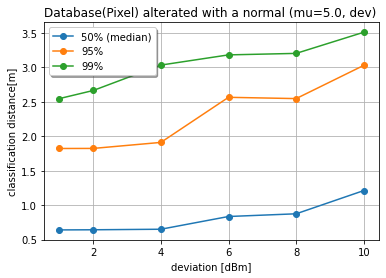

In [ ]:
def find_all_macs_floor(etaj):
    macse = set([])
    for c in etaj:
        f = c['fingerprints']
        allf = merge_wifi_fingerprints(f)['wifi']
        macse = macse | set(allf.keys())
    return macse
    #print("macs = ", len(macse))  
    
def find_all_macs_bldg(etaje):
    macs = set([])
    for e in etaje:     
        macs = macs | find_all_macs_floor(e)
    return macs # a set 

#apetaje[6][22]['fingerprints'][0]['wifi']['08:07:06:05:04:03']['rssi'] = [-78, -80]
# produces a new list of collections, copyi entries in the whitelist 
def select_whitelist(etaj, maclist):
    ne = []
    for c in etaj:
        nc = {}
        nc['fingerprints'] = []
        for f in c['fingerprints']:
            nf = {}
            nf['wifi']={}
            #print("fw=", f.keys(), "\n")
            for m in f['wifi']:
                if m in maclist:
                    nf['wifi'][m] = copy.deepcopy(f['wifi'][m])
            nc['fingerprints'].append(nf)
            for k in c:
                if k != 'fingerprints':
                    nc[k] = c[k]
        ne.append(nc)
    return ne
            
m0 = np.array(list(find_all_macs_floor(petaje[0])))

part0 = np.random.randint(m0.size, size=int(m0.size*0.4))

#print(m0, part0, m0[part0])

p0 = select_whitelist(petaje[0], m0[part0])
print(len(m0), len(find_all_macs_floor(p0)))
#print("p0=", p0)
  
print("compare ", 
      compare_locations(petaje[0][1], p0[2]))
print("compare ", 
      compare_locations(petaje[0][1], petaje[0][2]))



In [ ]:
def cross_validate(param):
    cl_sim = []
    cl_dist = [] 
    m0 = find_all_macs_floor(petaje[0])
    m0 = np.array(list(m0))
    for run in range(0,10):
        part0 = np.random.randint(m0.size, size=int(m0.size * param))
        apetaje = [select_whitelist(petaje[0], m0[part0])]
        #print(len(retaje), len(petaje), len(apetaje))
        for p in range(0, len(retaje)):
            for r in range(0, len(apetaje[p])):
                sim, index, d =  test_queryvsall(apetaje[p][r], retaje[p])
                cl_sim.append(sim)
                cl_dist.append(d)
                
    return (param, cl_dist, cl_sim)


res = []
for r in Pool(processes=cpu_count()).map(cross_validate, [ 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0]):
    perc = np.percentile(r[1], [50, 95, 99])
    #res.append([ r[0], perc[0], perc[1], perc[2]])  
    res.append(r)

In [ ]:
plt.style.use("seaborn-whitegrid")
"""
res = np.array(res)
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(res[:,0], res[:,1], "o-", label='50% (median)')
plt.plot(res[:,0], res[:,2], "o-", label='95%')
plt.plot(res[:,0], res[:,3], "o-", label='99%')
plt.xlabel('Fraction of APs used')
plt.ylabel('classification distance[m]')
plt.grid(True)
plt.title(f"Database(Pixel) resized (removed APs) ")
plt.legend(loc="upper left",shadow=True, fancybox=True)
plt.show()
fig.savefig(f"impairment_APs_reduced_0floor_face.pdf", bbox_inches='tight')
"""
print(ticks)
if True:
    fig1, ax1 = plt.subplots(figsize=(6, 4))
    ticks=[1.0-r[0] for r in res]
    bp = ax1.boxplot([r[1] for r in res ],  
                         positions=ticks, 
                         whis=(5,95),
                         widths=0.03)

    ax1.set_xticks(ticks)
    ax1.set_yticks(np.arange(0, 5.5, 0.5), minor=True)
    ax1.set_xticklabels(ticks)
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.set_xlim(-0.1, max(ticks)+0.1)
    ax1.set_ylim(0, 6)
    ax1.set_xlabel("Fraction of APs eliminated")
    ax1.set_ylabel("Distance to closest point [m]")
    plt.setp(bp['boxes'], color='k')
    plt.setp(bp['whiskers'], color='k', linestyle='-')
    plt.setp(bp['caps'], color='r', linewidth=3)
    plt.setp(bp["fliers"], markeredgecolor='k', marker='o', markersize=3.0, alpha=0.2)
    plt.setp(bp['medians'], color='#ff0011', linewidth=3)
    fig1.tight_layout()
    plt.show()
    fig1.savefig(f"impairment_APs_reduced_0floor_face1.pdf", bbox_inches='tight')

fig, ax = plt.subplots(figsize=(6, 4))

for r in reversed(res):
    plt.plot(sorted(r[1]), np.arange(len(r[1]))/len(r[1]), label=f"f = {r[0]}")
plt.axhline(y=1, color='r', linestyle='--')
plt.xlabel("Distance to closest point [m]")
plt.ylabel("CDF")
plt.title("Database(Pixel) reduced by removing APs")
plt.legend(loc="lower right",shadow=True, fancybox=True)
ax.set_xlim(0, 6)
plt.grid(True)
plt.tight_layout()
plt.show()
fig.savefig(f"impairment_APs_reduced_0floor_face2.pdf", bbox_inches='tight')

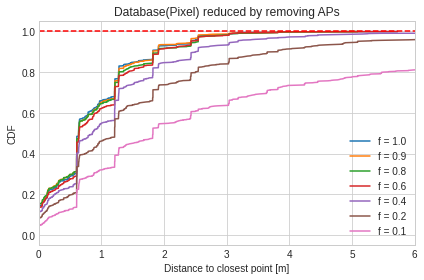

In [11]:
# distances to above below floors 
for e in range(0, len(petaje)):
    mine = []
    for p in petaje[e]:
        if e + 1 < len(petaje):
            dp = [ compare_locations(p, r) for r in retaje[e + 1]] 
            mine.append(np.min(dp))
        if e - 1 >= 0 :
            dp = [ compare_locations(p, r) for r in retaje[e - 1]] 
            mine.append(np.min(dp))
    print(e, np.min(mine), np.percentile(mine, [25, 50, 95]))


0 0.6762632197414805 [0.99442872 1.         1.04273428]
1 0.4161172161172161 [0.82392032 1.         1.05545316]
2 0.47899618112384085 [0.91354784 1.         1.        ]
3 0.6990116801437558 [1. 1. 1.]
4 0.6653333333333334 [0.96376745 1.         1.        ]
5 0.7811228641171684 [1. 1. 1.]
6 0.634191176470588 [1. 1. 1.]
7 0.7101604278074867 [1. 1. 1.]


#### pixel vs pixel, at least 33% common APs  
floor min_disim       25% 50% 95% 
0 0.7298772169167802 [0.97183157 1.         1.        ]
1 0.5025417574437185 [0.91551517 1.         1.32506704]
2 0.2924939467312349 [0.93802863 1.         1.        ]
3 0.7182222222222223 [1. 1. 1.]
4 0.7300855826201447 [1.         1.         1.24282965]
5 0.6117886178861789 [1.         1.         1.31197482]
6 0.805640243902439 [1. 1. 1.]
7 0.7681592039800994 [1.         1.         1.64676537]
#### pixel vs redmi  at least 33% common APs  
0 0.6762632197414805 [0.99442872 1.         1.04273428]
1 0.4161172161172161 [0.82392032 1.         1.05545316]
2 0.47899618112384085 [0.91354784 1.         1.        ]
3 0.6990116801437558 [1. 1. 1.]
4 0.6653333333333334 [0.96376745 1.         1.        ]
5 0.7811228641171684 [1. 1. 1.]
6 0.634191176470588 [1. 1. 1.]
7 0.7101604278074867 [1. 1. 1.]

In [ ]:
# just various testing 

wifi1 = merge_wifi_fingerprints(petaje[0][22]['fingerprints'])['wifi']
wifi2 = merge_wifi_fingerprints(apetaje[0][22]['fingerprints'])['wifi']
common_aps = list(set(wifi1.keys()) & set(wifi2.keys()))
wifi1 = {m:wifi1[m] for m in (common_aps)}
wifi2 = {m:wifi2[m] for m in (common_aps)}

w1 = list(map(lambda w: np.mean(w[1]['rssi']), wifi1.items()))
w2 = list(map(lambda w: np.mean(w[1]['rssi']), wifi2.items()))
print(w1)
print(w2)
print(np.cov(np.stack((w1, w2), axis=0)))         
print(len(petaje))
print(petaje[6][22]['fingerprints'][0]['wifi'])
#print(apetaje[6][22]['fingerprints'][0]['wifi'])